# **Cigarettes Counting Simple Project with Yolo**

## **Import Library**

In [1]:
import os

from ultralytics import YOLO
from IPython.display import Image
import pandas as pd

## **Training Model YOLOv8**

In [2]:
model = YOLO('yolov8n.pt')
model.train(
    data='cigarettes.yaml',
    epochs=50,
    imgsz=640,
    batch=8
)

/home/refanzzzz/miniconda3/envs/cigarettes-yolo/lib/python3.12/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(
100%|██████████| 6.25M/6.25M [00:01<00:00, 4.42MB/s]


Ultralytics 8.3.140 🚀 Python-3.12.9 torch-2.7.0+cu126 CPU (Intel Core(TM) i3-1005G1 1.20GHz)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=cigarettes.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pretrained=True

train: Scanning /home/refanzzzz/PycharmProjects/cigarettes-yolo/data/labels/train.cache... 4 images, 0 backgrounds, 0 corrupt: 100%|██████████| 4/4 [00:00<?, ?it/s]

val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 4078.1±0.0 MB/s, size: 460.5 KB)



/home/refanzzzz/miniconda3/envs/cigarettes-yolo/lib/python3.12/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
val: Scanning /home/refanzzzz/PycharmProjects/cigarettes-yolo/data/labels/val.cache... 1 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1/1 [00:00<?, ?it/s]
/home/refanzzzz/miniconda3/envs/cigarettes-yolo/lib/python3.12/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs/detect/train
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50         0G     0.9864      3.388       1.04        127        640: 100%|██████████| 1/1 [00:02<00:00,  2.63s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.45it/s]

                   all          1        117      0.267      0.684      0.234      0.172



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50         0G      1.249      3.474      1.184        169        640: 100%|██████████| 1/1 [00:02<00:00,  2.54s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.52it/s]

                   all          1        117      0.287      0.735      0.257      0.191



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50         0G      1.239      3.537      1.194        385        640: 100%|██████████| 1/1 [00:02<00:00,  2.70s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.08it/s]

                   all          1        117      0.307      0.786      0.295      0.217



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50         0G      1.101      3.472      1.136        252        640: 100%|██████████| 1/1 [00:02<00:00,  2.64s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.49it/s]

                   all          1        117       0.34      0.872      0.357      0.264



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50         0G      1.054       3.29      1.053        199        640: 100%|██████████| 1/1 [00:02<00:00,  2.70s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.89it/s]

                   all          1        117       0.36      0.923      0.409      0.299



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50         0G     0.8022      3.027     0.9738         85        640: 100%|██████████| 1/1 [00:04<00:00,  4.45s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.37it/s]

                   all          1        117       0.38      0.974       0.46      0.333



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50         0G      1.056      2.997      1.083        154        640: 100%|██████████| 1/1 [00:04<00:00,  4.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.28it/s]

                   all          1        117      0.383      0.983      0.489      0.353



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50         0G       1.06       2.98      1.025        238        640: 100%|██████████| 1/1 [00:04<00:00,  4.23s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.96it/s]

                   all          1        117       0.38      0.974      0.495      0.362



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50         0G     0.9453      2.547     0.9822        131        640: 100%|██████████| 1/1 [00:03<00:00,  3.28s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.42it/s]

                   all          1        117       0.38      0.974      0.495      0.362



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50         0G     0.8329      2.533     0.9473        115        640: 100%|██████████| 1/1 [00:02<00:00,  2.52s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.76it/s]

                   all          1        117       0.38      0.974      0.492       0.37



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50         0G     0.9624      2.642      1.002        204        640: 100%|██████████| 1/1 [00:02<00:00,  2.86s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.50it/s]

                   all          1        117       0.38      0.974      0.492       0.37



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50         0G      1.144      2.793     0.9774        286        640: 100%|██████████| 1/1 [00:04<00:00,  4.61s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.81it/s]

                   all          1        117       0.38      0.974      0.495      0.379



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50         0G     0.8624      2.215     0.9053        170        640: 100%|██████████| 1/1 [00:03<00:00,  3.99s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.97it/s]

                   all          1        117       0.38      0.974      0.495      0.379



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50         0G      1.115      2.257     0.9509        152        640: 100%|██████████| 1/1 [00:03<00:00,  3.65s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.45it/s]

                   all          1        117      0.383      0.983      0.492      0.387



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50         0G      1.133      2.615      0.972        406        640: 100%|██████████| 1/1 [00:03<00:00,  3.76s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.25it/s]

                   all          1        117      0.383      0.983      0.492      0.387



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50         0G      1.063      2.301     0.9062        270        640: 100%|██████████| 1/1 [00:02<00:00,  2.76s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.52it/s]

                   all          1        117      0.387      0.991      0.476      0.362



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50         0G     0.9079       1.55     0.9339        121        640: 100%|██████████| 1/1 [00:02<00:00,  2.40s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.70it/s]

                   all          1        117      0.387      0.991      0.476      0.362



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50         0G     0.9037       1.54       1.02         83        640: 100%|██████████| 1/1 [00:03<00:00,  3.23s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.64it/s]

                   all          1        117      0.387      0.991      0.478      0.361



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50         0G      1.076      2.088     0.9147        348        640: 100%|██████████| 1/1 [00:04<00:00,  4.20s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.36it/s]

                   all          1        117      0.387      0.991      0.478      0.361



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50         0G      0.836      1.269     0.9064        104        640: 100%|██████████| 1/1 [00:03<00:00,  3.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.85it/s]

                   all          1        117      0.387      0.991      0.581      0.446



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50         0G     0.9617      1.237      0.954        134        640: 100%|██████████| 1/1 [00:02<00:00,  2.57s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.54it/s]

                   all          1        117      0.387      0.991      0.581      0.446



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50         0G       1.07       1.44     0.9938        189        640: 100%|██████████| 1/1 [00:02<00:00,  2.35s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.97it/s]

                   all          1        117      0.387      0.991      0.724      0.547



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50         0G     0.9384      1.077     0.9339        149        640: 100%|██████████| 1/1 [00:03<00:00,  3.20s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.74it/s]

                   all          1        117      0.387      0.991      0.724      0.547



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50         0G     0.9776      1.173     0.9351        168        640: 100%|██████████| 1/1 [00:02<00:00,  2.92s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.05it/s]

                   all          1        117      0.387      0.991      0.724      0.547



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50         0G     0.9049      1.117     0.9808        100        640: 100%|██████████| 1/1 [00:01<00:00,  1.95s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.01it/s]

                   all          1        117       0.39          1      0.898      0.677



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50         0G      1.149      1.097      0.982        192        640: 100%|██████████| 1/1 [00:02<00:00,  2.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.50it/s]

                   all          1        117       0.39          1      0.898      0.677



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50         0G     0.8571      1.024     0.9802        126        640: 100%|██████████| 1/1 [00:01<00:00,  1.86s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.62it/s]

                   all          1        117       0.39          1      0.898      0.677



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50         0G     0.9051      1.068     0.9343        141        640: 100%|██████████| 1/1 [00:02<00:00,  2.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.45it/s]

                   all          1        117       0.39          1      0.956      0.737



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50         0G     0.9868      1.113     0.9347        207        640: 100%|██████████| 1/1 [00:04<00:00,  4.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.58it/s]

                   all          1        117       0.39          1      0.956      0.737



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50         0G     0.8976          1     0.9749         80        640: 100%|██████████| 1/1 [00:02<00:00,  2.51s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.84it/s]

                   all          1        117       0.39          1      0.956      0.737



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50         0G      1.063      1.354     0.9186        309        640: 100%|██████████| 1/1 [00:03<00:00,  3.52s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.14it/s]

                   all          1        117       0.39          1      0.969      0.769



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50         0G      1.016     0.9849     0.9328        186        640: 100%|██████████| 1/1 [00:02<00:00,  2.86s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.88it/s]

                   all          1        117       0.39          1      0.969      0.769



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50         0G      0.752      0.787      0.937         77        640: 100%|██████████| 1/1 [00:03<00:00,  3.63s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.69it/s]

                   all          1        117       0.39          1      0.969      0.769



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50         0G     0.8746     0.9633     0.9026        198        640: 100%|██████████| 1/1 [00:02<00:00,  2.99s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.19it/s]

                   all          1        117       0.39          1      0.981      0.775



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50         0G     0.8088     0.9141     0.9715        129        640: 100%|██████████| 1/1 [00:04<00:00,  4.37s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.37it/s]

                   all          1        117       0.39          1      0.981      0.775



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50         0G     0.9371       1.14     0.9638        237        640: 100%|██████████| 1/1 [00:02<00:00,  2.68s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.64it/s]

                   all          1        117       0.39          1      0.981      0.775



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50         0G      1.001     0.9947     0.9378        225        640: 100%|██████████| 1/1 [00:02<00:00,  2.28s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.96it/s]

                   all          1        117       0.39          1      0.981      0.775



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50         0G     0.9314     0.7134     0.9276        139        640: 100%|██████████| 1/1 [00:02<00:00,  2.51s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.42it/s]

                   all          1        117       0.39          1      0.989      0.769



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50         0G     0.8666     0.7216     0.9206        117        640: 100%|██████████| 1/1 [00:01<00:00,  1.97s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.52it/s]

                   all          1        117       0.39          1      0.989      0.769



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50         0G     0.9873      1.021     0.9613        251        640: 100%|██████████| 1/1 [00:01<00:00,  1.96s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.17it/s]

                   all          1        117       0.39          1      0.989      0.769


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


/home/refanzzzz/miniconda3/envs/cigarettes-yolo/lib/python3.12/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
      41/50         0G     0.8428     0.6366     0.9567         90        640: 100%|██████████| 1/1 [00:02<00:00,  2.46s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]

                   all          1        117       0.39          1      0.989      0.769



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50         0G     0.8622     0.6999     0.9624         86        640: 100%|██████████| 1/1 [00:01<00:00,  1.80s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.99it/s]

                   all          1        117       0.39          1      0.992      0.773



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50         0G     0.8852     0.7132     0.9223         97        640: 100%|██████████| 1/1 [00:01<00:00,  1.99s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.25it/s]

                   all          1        117       0.39          1      0.992      0.773



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50         0G      0.895     0.6291     0.9503         94        640: 100%|██████████| 1/1 [00:02<00:00,  2.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.25it/s]

                   all          1        117       0.39          1      0.992      0.773



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50         0G     0.8908     0.6778     0.9369         97        640: 100%|██████████| 1/1 [00:01<00:00,  2.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.54it/s]

                   all          1        117       0.39          1      0.992      0.773



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50         0G     0.8471      0.703     0.9824         91        640: 100%|██████████| 1/1 [00:03<00:00,  3.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.81it/s]

                   all          1        117      0.552          1      0.994      0.769



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50         0G      0.841     0.7089     0.9603         84        640: 100%|██████████| 1/1 [00:02<00:00,  2.44s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.53it/s]

                   all          1        117      0.552          1      0.994      0.769



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50         0G     0.8446     0.6223     0.9685         93        640: 100%|██████████| 1/1 [00:01<00:00,  1.89s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.69it/s]

                   all          1        117      0.552          1      0.994      0.769



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50         0G     0.8439     0.6238     0.9762         88        640: 100%|██████████| 1/1 [00:02<00:00,  2.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.70it/s]

                   all          1        117      0.552          1      0.994      0.769



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50         0G     0.8854     0.6512     0.8838         97        640: 100%|██████████| 1/1 [00:01<00:00,  1.90s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.81it/s]

                   all          1        117          1      0.934      0.994      0.771



50 epochs completed in 0.053 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train/weights/best.pt, 6.2MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.140 🚀 Python-3.12.9 torch-2.7.0+cu126 CPU (Intel Core(TM) i3-1005G1 1.20GHz)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.55it/s]


                   all          1        117       0.39          1      0.981      0.775
Speed: 1.2ms preprocess, 214.4ms inference, 0.0ms loss, 13.9ms postprocess per image
Results saved to runs/detect/train


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x76e07c06c680>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

## **Evaluating Model**

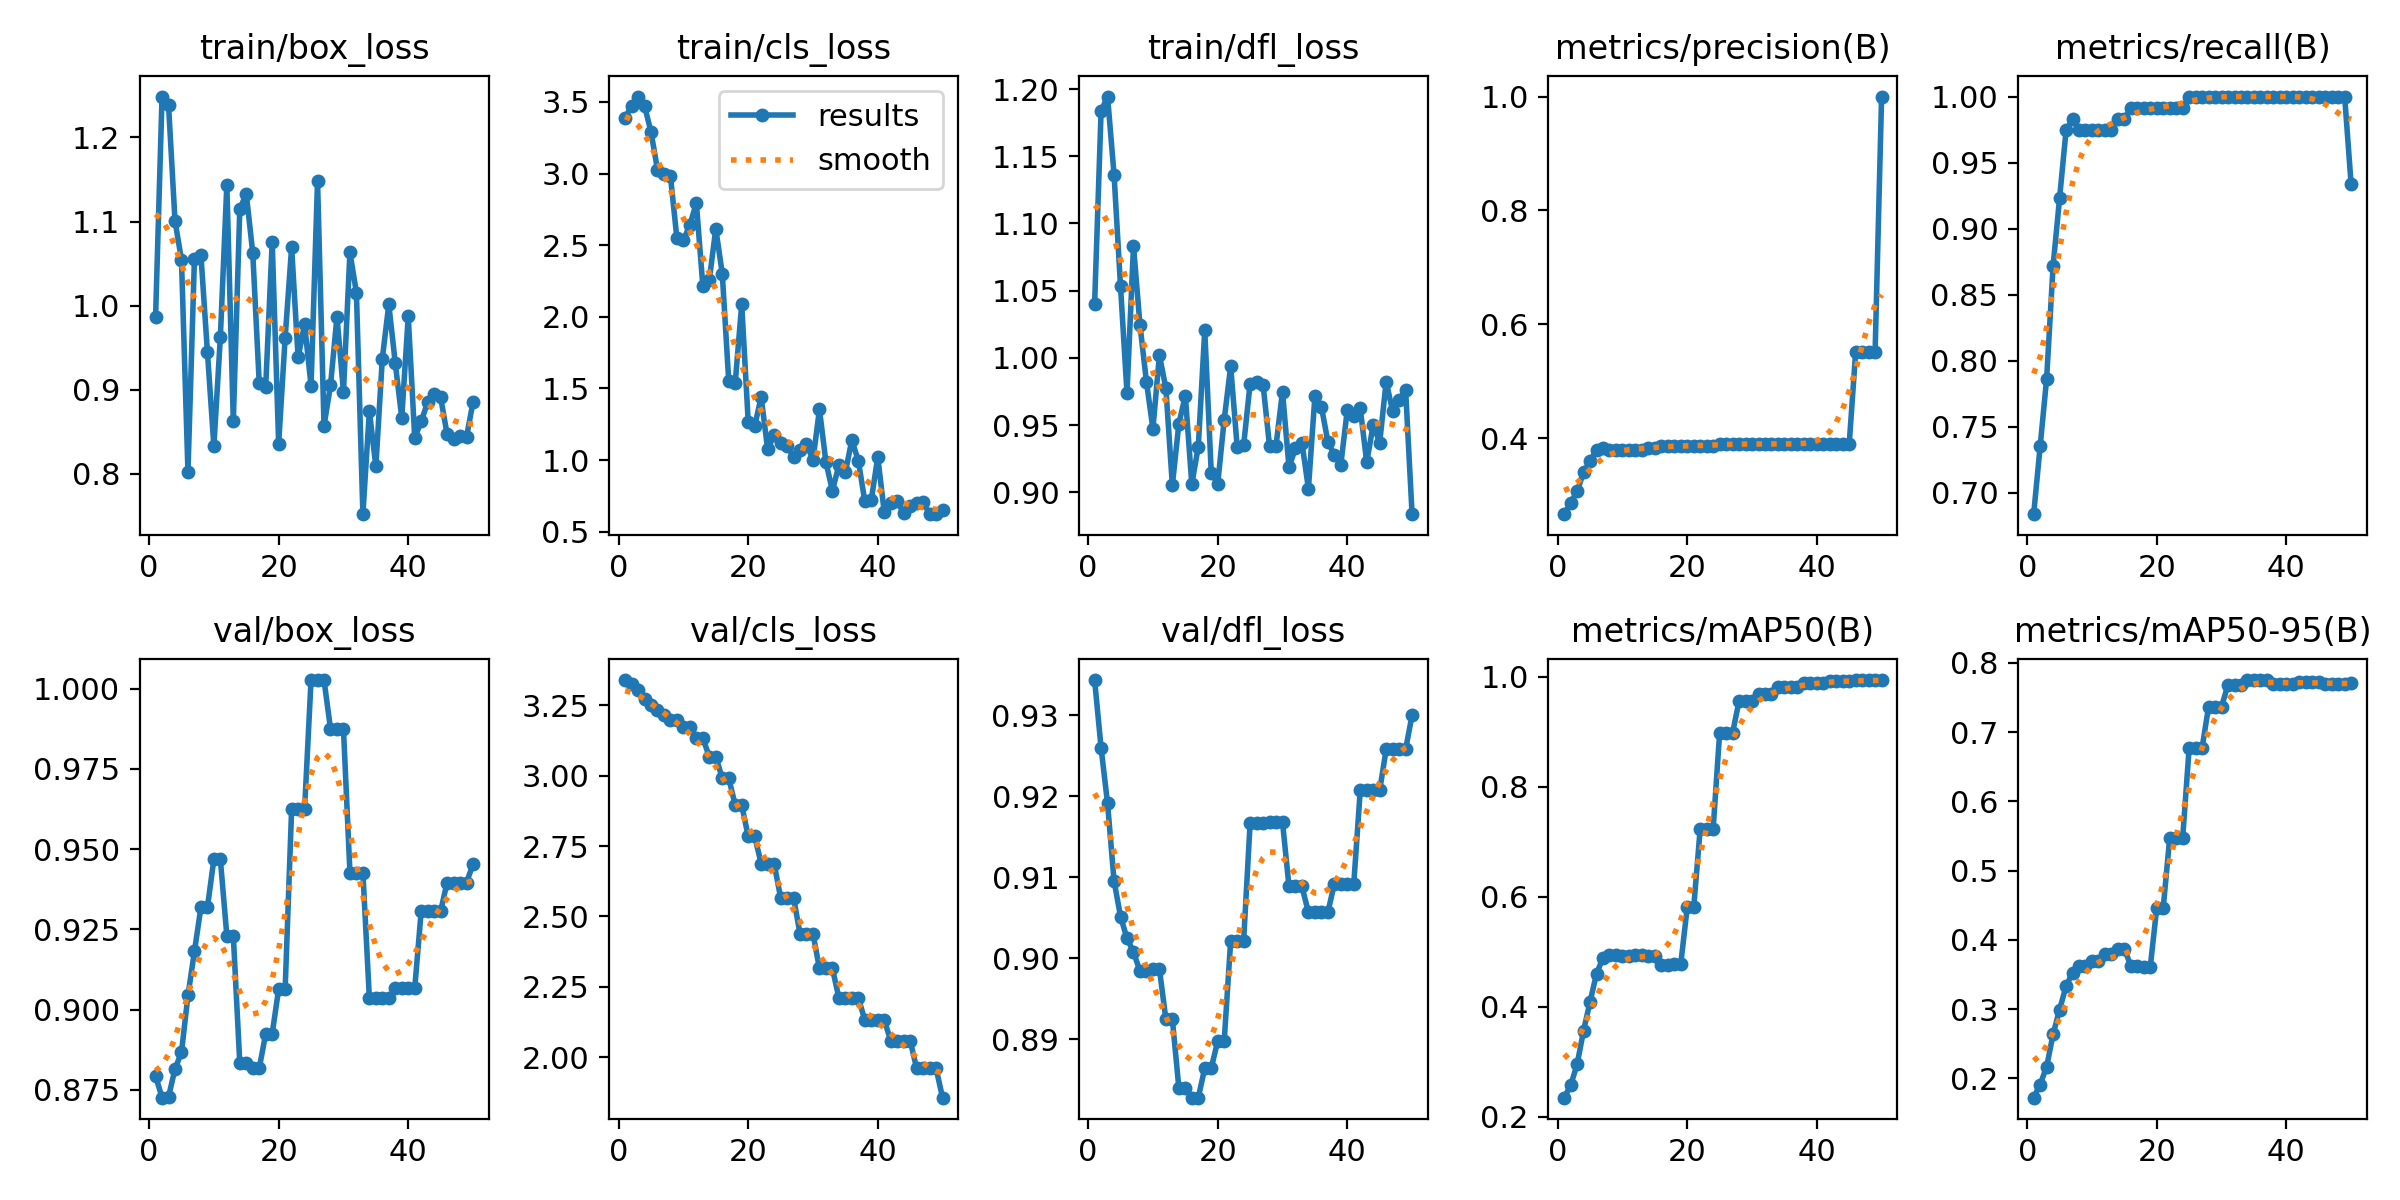

In [3]:
Image('runs/detect/train/results.png')

In [4]:
metric_df = pd.read_csv('runs/detect/train/results.csv')
metric_df

,epoch,time,train/box_loss,train/cls_loss,train/dfl_loss,metrics/precision(B),metrics/recall(B),metrics/mAP50(B),metrics/mAP50-95(B),val/box_loss,val/cls_loss,val/dfl_loss,lr/pg0,lr/pg1,lr/pg2
0,1,3.35893,0.98641,3.38768,1.04021,0.26667,0.68376,0.23450,0.17194,0.87938,3.34046,0.93437,0.000000,0.000000,0.000000
1,2,6.81878,1.24867,3.47353,1.18360,0.28667,0.73504,0.25668,0.19093,0.87260,3.32585,0.92598,0.000020,0.000020,0.000020
2,3,10.52220,1.23895,3.53724,1.19440,0.30667,0.78632,0.29497,0.21651,0.87285,3.30568,0.91912,0.000038,0.000038,0.000038
3,4,14.02360,1.10073,3.47200,1.13626,0.34000,0.87179,0.35657,0.26365,0.88155,3.27477,0.90955,0.000056,0.000056,0.000056
4,5,17.37440,1.05442,3.28996,1.05315,0.36000,0.92308,0.40900,0.29919,0.88673,3.25274,0.90516,0.000074,0.000074,0.000074
5,6,22.92340,0.80221,3.02745,0.97382,0.38000,0.97436,0.46016,0.33285,0.90445,3.23318,0.90246,0.000090,0.000090,0.000090
6,7,28.07640,1.05590,2.99685,1.08332,0.38333,0.98291,0.48879,0.35264,0.91819,3.21730,0.90078,0.000106,0.000106,0.000106
7,8,33.22030,1.06014,2.98046,1.02456,0.38000,0.97436,0.49497,0.36229,0.93185,3.19770,0.89840,0.000121,0.000121,0.000121
8,9,37.36860,0.94528,2.54656,0.98217,0.38000,0.97436,0.49497,0.36229,0.93185,3.19770,0.89840,0.000135,0.000135,0.000135
9,10,40.99320,0.83292,2.53331,0.94732,0.38000,0.97436,0.49248,0.36973,0.94684,3.17371,0.89869,0.000148,0.000148,0.000148


In [5]:
metric_df.describe()

,epoch,time,train/box_loss,train/cls_loss,train/dfl_loss,metrics/precision(B),metrics/recall(B),metrics/mAP50(B),metrics/mAP50-95(B),val/box_loss,val/cls_loss,val/dfl_loss,lr/pg0,lr/pg1,lr/pg2
count,50.00000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000
mean,25.50000,101.725572,0.957039,1.602404,0.971703,0.404965,0.972516,0.739588,0.569424,0.926029,2.615315,0.907439,0.000170,0.000170,0.000170
std,14.57738,56.276211,0.116010,0.960012,0.064761,0.101329,0.065623,0.260609,0.208832,0.035560,0.481345,0.013609,0.000075,0.000075,0.000075
min,1.00000,3.358930,0.752010,0.622300,0.883760,0.266670,0.683760,0.234500,0.171940,0.872600,1.855680,0.882780,0.000000,0.000000,0.000000
25%,13.25000,56.688100,0.863482,0.818777,0.934000,0.383330,0.976498,0.492420,0.364150,0.903600,2.151378,0.898690,0.000115,0.000115,0.000115
50%,25.50000,103.364000,0.934270,1.128385,0.960830,0.390000,0.995725,0.898260,0.677460,0.926895,2.567240,0.908870,0.000191,0.000191,0.000191
75%,37.75000,152.126500,1.055530,2.475283,0.981698,0.390000,1.000000,0.986808,0.769402,0.942740,3.117188,0.916840,0.000236,0.000236,0.000236
max,50.00000,189.197000,1.248670,3.537240,1.194400,1.000000,1.000000,0.994320,0.775140,1.002690,3.340460,0.934370,0.000253,0.000253,0.000253


## **Testing Model**

## **Testing 1**

In [13]:
model = YOLO('runs/detect/train/weights/best.pt')
image_test = 'data/testing/rokok-test-2.jpg'

results = model.predict(image_test, conf=0.05, save=True)


image 1/1 /home/refanzzzz/PycharmProjects/cigarettes-yolo/data/rokok-1.jpg: 448x640 14 cigarettes, 209.5ms
Speed: 16.7ms preprocess, 209.5ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)
Results saved to runs/detect/predict2


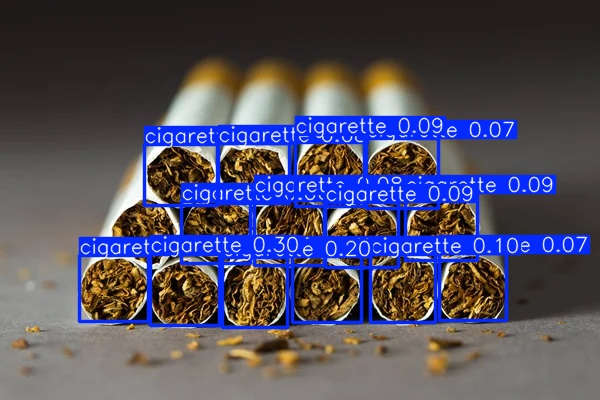

In [19]:
def check_predict_result(result):
    predict_result_path = result[0].save_dir
    predict_img = os.path.join(predict_result_path, os.listdir(predict_result_path)[0])

    return predict_img

Image(check_predict_result(results))

## **Testing 2**


image 1/1 /home/refanzzzz/PycharmProjects/cigarettes-yolo/data/testing/rokok-test-1.jpeg: 480x640 52 cigarettes, 223.6ms
Speed: 9.2ms preprocess, 223.6ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)
Results saved to runs/detect/predict2


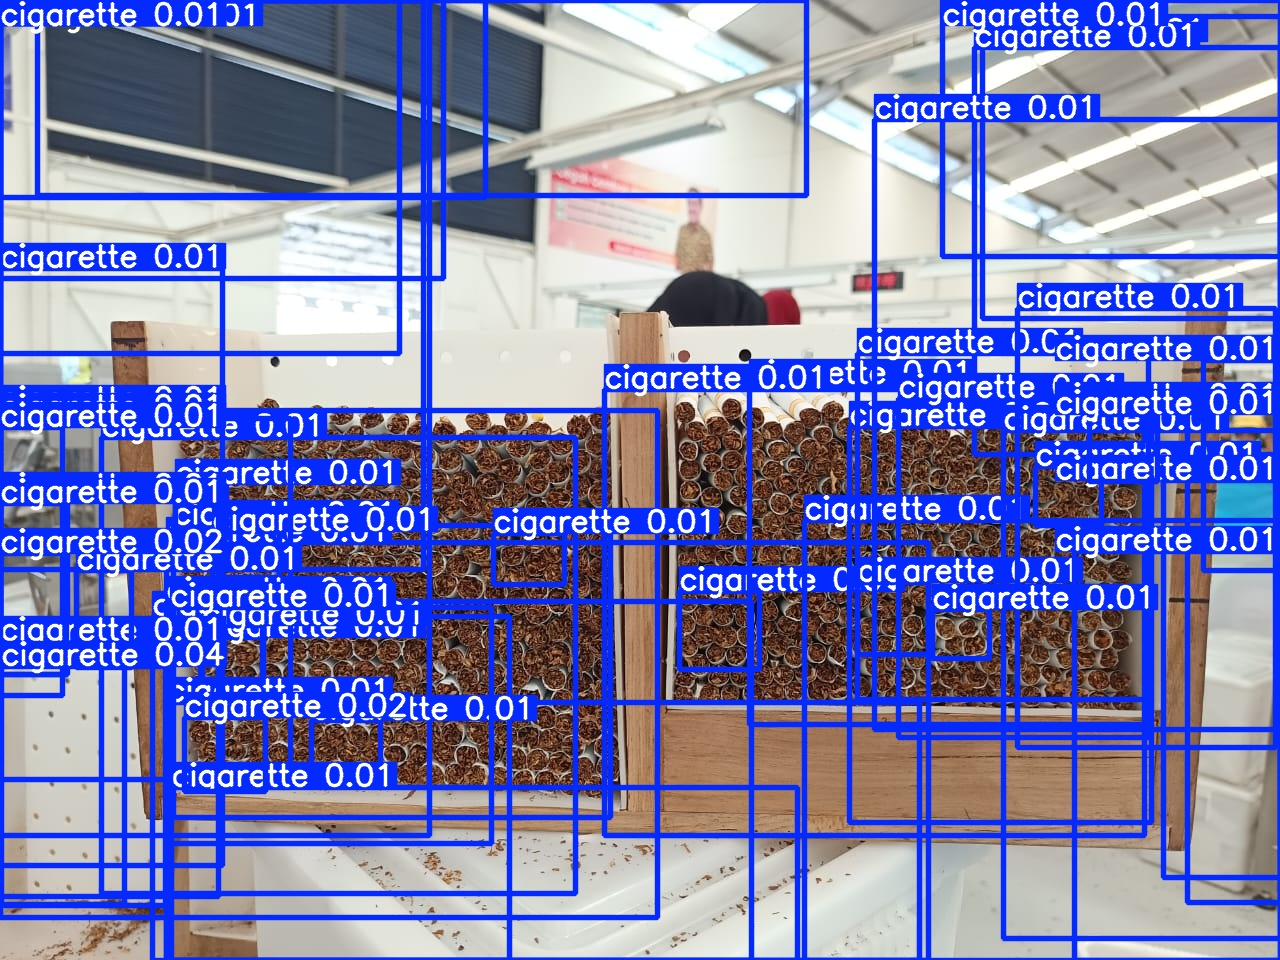

In [26]:
image_test = 'data/testing/rokok-test-1.jpeg'
results_2 = model.predict(image_test, conf=0.01, save=True)

Image(check_predict_result(results_2))